In [2]:
import os
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

tf.random.set_seed(1234)

In [3]:
# Contains txt files
path_data = r'C:\Users\hnkev\Downloads\W207 Final Project\\'

label_dir = path_data + 'garbage_txt\\'
# Contains img files
image_dir = path_data + 'garbage_img\\'

# Read labels

In [4]:
# Read train, validation, test split from txt files
train_file = label_dir + 'one-indexed-files-notrash_train.txt'
val_file   = label_dir + 'one-indexed-files-notrash_val.txt'
test_file  = label_dir + 'one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['path', 'label'])
df_test  = pd.read_csv(test_file,   sep=' ', header=None, names=['path', 'label'])

# Converts label id to name
def label_id_to_name(id):
  label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
  return label_map[id]

df_train['label'] = df_train['label'].apply(label_id_to_name)
df_valid['label'] = df_valid['label'].apply(label_id_to_name)
df_test['label'] = df_test['label'].apply(label_id_to_name)

# Change file name to file path i.e. cardboard114.jpg	 to cardboard/cardboard114.jpg	
df_train.path = df_train.path.str.extract(r'([a-z]+)')[0] + "\\" + df_train.path
df_valid.path = df_valid.path.str.extract(r'([a-z]+)')[0] + "\\" + df_valid.path
df_test.path = df_test.path.str.extract(r'([a-z]+)')[0] + "\\" + df_test.path

In [5]:
df_train[:1]

,path,label
0,cardboard\cardboard202.jpg,cardboard


In [6]:
display(df_train.head())
display(df_valid.head())
display(df_test.head())

,path,label
0,cardboard\cardboard202.jpg,cardboard
1,paper\paper472.jpg,paper
2,paper\paper522.jpg,paper
3,glass\glass189.jpg,glass
4,glass\glass325.jpg,glass


,path,label
0,cardboard\cardboard114.jpg,cardboard
1,plastic\plastic204.jpg,plastic
2,glass\glass123.jpg,glass
3,glass\glass152.jpg,glass
4,glass\glass398.jpg,glass


,path,label
0,paper\paper70.jpg,paper
1,paper\paper380.jpg,paper
2,cardboard\cardboard31.jpg,cardboard
3,glass\glass12.jpg,glass
4,paper\paper169.jpg,paper


In [7]:
print("Size of training data", len(df_train))
print("Size of validation data", len(df_valid))
print("Size of test data", len(df_test))

Size of training data 1768
Size of validation data 328
Size of test data 431


In [8]:
def myFunc(image):
    hsv_image = cv2.cvtColor(np.uint8(image),cv2.COLOR_RGB2HSV)
    hsv_image_transf = hsv_image + np.array([random.randint(0, 128), 0, 0])
    hsv_to_rgb = cv2.cvtColor(np.uint8(hsv_image_transf),cv2.COLOR_HSV2RGB)
    return cv2.resize(np.float64(hsv_to_rgb), dsize=(224, 224))

# Read images

In [29]:
# Set data directory and parameters
batch_size = 32
image_size = (224,224)

# Create data generator with data augmentation and shuffling
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.3,
    #brightness_range=(0.2, 0.8),
    horizontal_flip=True,
    vertical_flip=True,
    #preprocessing_function=myFunc,
    #fill_mode='nearest',
)

# Load train, validation, and test data from all dataframes
train_data = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = image_dir,
    x_col = 'path',
    y_col= 'label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1234
)

val_data = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = image_dir,
    x_col = 'path',
    y_col= 'label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1234
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


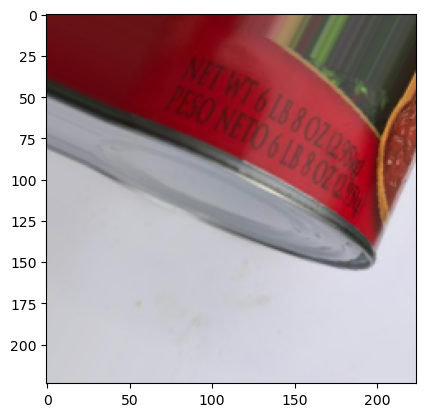

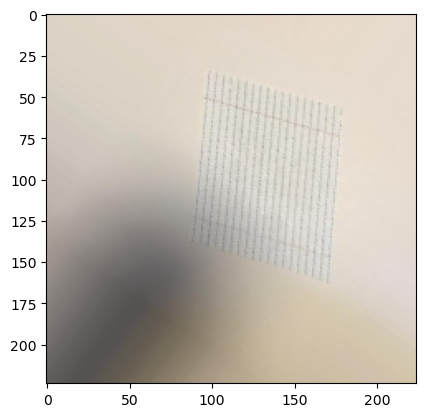

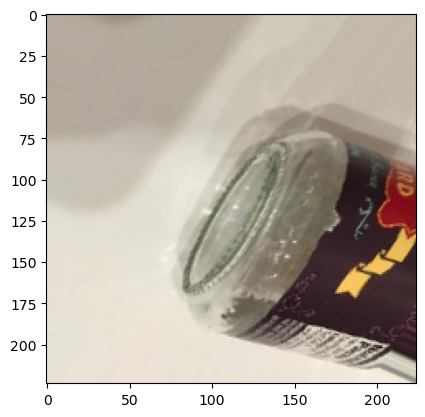

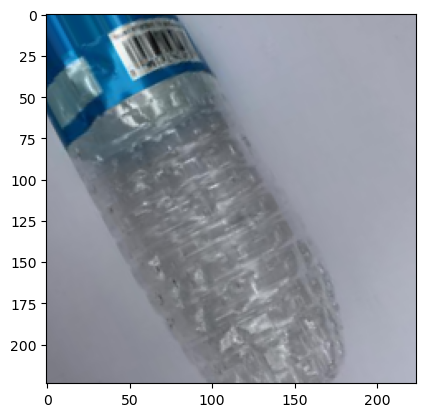

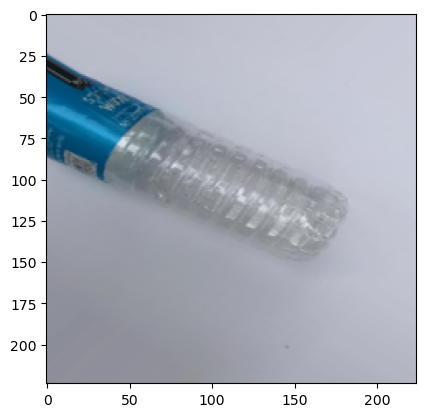

In [30]:
for _ in range(5):
    img, label = train_data.next()
    plt.imshow(img[0])
    plt.show()

# Construct model

In [31]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples // batch_size,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
)

Epoch 1/10
55/55 [==============================] - 123s 2s/step - loss: 2.0419 - accuracy: 0.2609 - val_loss: 1.4874 - val_accuracy: 0.3906
Epoch 2/10
55/55 [==============================] - 105s 2s/step - loss: 1.4509 - accuracy: 0.4113 - val_loss: 1.5368 - val_accuracy: 0.4313
Epoch 3/10
55/55 [==============================] - 137s 2s/step - loss: 1.3694 - accuracy: 0.4528 - val_loss: 1.3322 - val_accuracy: 0.4906
Epoch 4/10
55/55 [==============================] - 132s 2s/step - loss: 1.2391 - accuracy: 0.4954 - val_loss: 1.2395 - val_accuracy: 0.5063
Epoch 5/10
55/55 [==============================] - 176s 3s/step - loss: 1.1927 - accuracy: 0.5236 - val_loss: 1.2575 - val_accuracy: 0.5219
Epoch 6/10
55/55 [==============================] - 173s 3s/step - loss: 1.1721 - accuracy: 0.5490 - val_loss: 1.2031 - val_accuracy: 0.5531
Epoch 7/10
55/55 [==============================] - 150s 3s/step - loss: 1.1125 - accuracy: 0.5634 - val_loss: 1.1640 - val_accuracy: 0.5500
Epoch 8/10
55

In [32]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 128)     

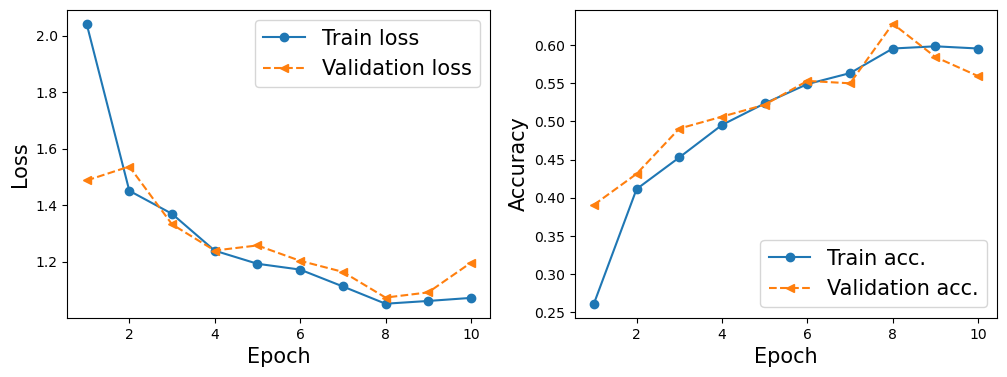

In [33]:
# Plot loss and accuracy data
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

# One vs. All Model

### Train 6 different binary classification models and combine them, taking the argmax of binary probabilities to do multiclass prediction.

In [30]:
label_list = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

In [49]:
#6 different lists for binary classification of labels for both train and validation

y_train_dict = {}
y_valid_dict = {}

for label in label_list:
    
    df_train_lab = pd.DataFrame(df_train.path)
    df_valid_lab = pd.DataFrame(df_valid.path)
    
    df_train_lab['label'] = (df_train.label == label).astype(str)
    df_valid_lab['label'] = (df_valid.label == label).astype(str)
     
    y_train_dict[label] = df_train_lab
    y_valid_dict[label] = df_valid_lab

In [50]:
#ImageDataGenerator plus transformations

# Set data directory and parameters
batch_size = 32
image_size = (224,224)

# Create data generator with data augmentation and shuffling
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

train_data_dict = {}
valid_data_dict = {}

for label in label_list:
    
    # Load train, validation, and test data from all dataframes
    train_data = datagen.flow_from_dataframe(
        dataframe = y_train_dict[label],
        directory = image_dir,
        x_col = 'path',
        y_col= 'label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=1234
    )

    val_data = datagen.flow_from_dataframe(
        dataframe = y_valid_dict[label],
        directory = image_dir,
        x_col = 'path',
        y_col= 'label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=1234
    )
    
    train_data_dict[label] = train_data
    valid_data_dict[label] = val_data

Found 1768 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.
Found 328 validated image filenames belonging to 2 classes.


In [68]:
train_data_dict[label].samples

1768

In [72]:
#Train 6 different binary neural nets

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_dict = {}

for label in label_list:
    model_dict[label] = model
    
    model_dict[label].fit(train_data_dict[label],
                          steps_per_epoch=train_data_dict[label].samples // batch_size,
                          epochs=5,
                          validation_data=valid_data_dict[label],
                          validation_steps=valid_data_dict[label].samples // batch_size)

Epoch 1/5
55/55 [==============================] - 113s 2s/step - loss: 0.7301 - accuracy: 0.7776 - val_loss: 0.4860 - val_accuracy: 0.8000
Epoch 2/5
55/55 [==============================] - 90s 2s/step - loss: 0.4823 - accuracy: 0.7995 - val_loss: 0.4972 - val_accuracy: 0.8000
Epoch 3/5
55/55 [==============================] - 95s 2s/step - loss: 0.4663 - accuracy: 0.7967 - val_loss: 0.4427 - val_accuracy: 0.8031
Epoch 4/5
55/55 [==============================] - 105s 2s/step - loss: 0.4515 - accuracy: 0.8007 - val_loss: 0.4638 - val_accuracy: 0.7969
Epoch 5/5
55/55 [==============================] - 117s 2s/step - loss: 0.4456 - accuracy: 0.7995 - val_loss: 0.4222 - val_accuracy: 0.8062
Epoch 1/5
55/55 [==============================] - 136s 3s/step - loss: 0.5576 - accuracy: 0.7719 - val_loss: 0.5160 - val_accuracy: 0.7500
Epoch 2/5
55/55 [==============================] - 147s 3s/step - loss: 0.5052 - accuracy: 0.7730 - val_loss: 0.5093 - val_accuracy: 0.7781
Epoch 3/5
55/55 [=====

In [81]:
valid_array = np.array(image_dir + df_valid.path)

In [108]:
pred_logits = model_dict['glass'].predict(train_data)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100
probas

56/56 [==============================] - 83s 1s/step


array([50.009842, 50.063385, 54.95595 , ..., 50.00001 , 50.001293,
       50.365234], dtype=float32)

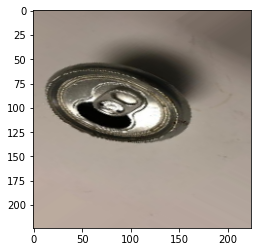

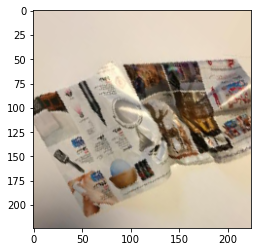

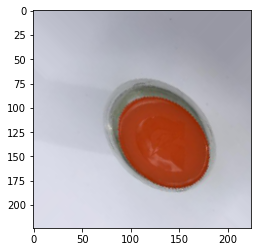

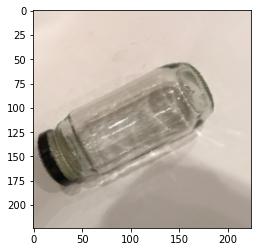

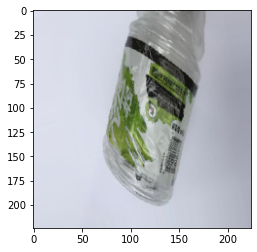

In [107]:
for i in range(5):
    img, label = valid_data_dict['glass'].next()
    plt.imshow(img[0])
    plt.show()

In [100]:
model_dict['glass'].evaluate(valid_data_dict['glass'])

11/11 [==============================] - 16s 1s/step - loss: 1.3751 - accuracy: 0.8018


[1.375146746635437, 0.8018292784690857]

# Evaluate model performance

In [34]:
# Evaluate model performance on test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=image_dir,
    x_col="path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=1234
)

test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Found 328 validated image filenames belonging to 6 classes.
11/11 [==============================] - 5s 419ms/step - loss: 1.1046 - accuracy: 0.5854
Test loss: 1.104604721069336
Test accuracy: 0.5853658318519592


11/11 [==============================] - 5s 423ms/step


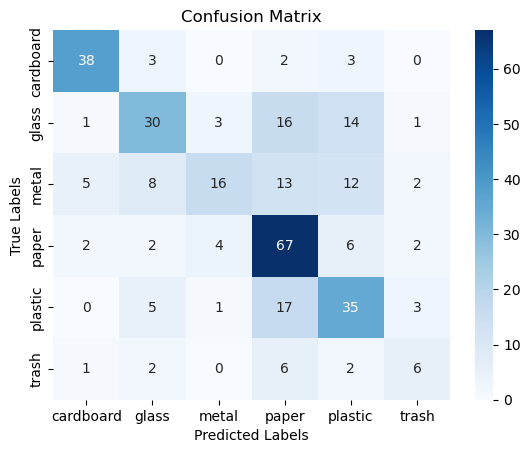

In [35]:
# Print confusion matrix

y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

cm = confusion_matrix(y_true_labels, y_pred_labels)
# Create heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
sum(cm)

array([ 47,  50,  24, 121,  72,  14], dtype=int64)

In [ ]:
# Print few wrongly classified images

wrong_indices = np.where(y_true_labels != y_pred_labels)[0]
num_samples = 5
samples = np.random.choice(wrong_indices, size=num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))

for i, sample in enumerate(samples):
    img_path = test_data.filepaths[sample]
    img = plt.imread(img_path)
    true_label = class_names[y_true_labels[sample]]
    predicted_label = class_names[y_pred_labels[sample]]
    axes[i].imshow(img)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    
plt.tight_layout()
plt.show()